# Python演習４
## 伝達関数モデルを用いた制御系設計

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

### フィードバック系のステップ応答

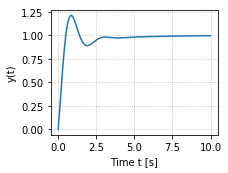

In [2]:
P = tf([0, 1],[1, 1 ,1])
C = tf([2, 10, 3],[1, 0])

Gyr = feedback(P*C, 1)
y,t = step(Gyr,np.arange(0, 10, 0.01))

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t,y)
ax.set_xlabel('Time t [s]')
ax.set_ylabel('y(t)')
ax.grid(ls=':')

### フィードバック系の周波数応答

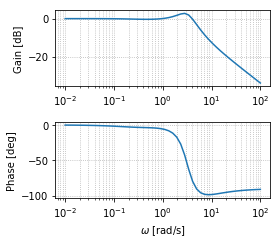

In [3]:
P = tf([0, 1],[1, 1 ,1])
C = tf([2, 10, 3],[1, 0])
Gyr = feedback(P*C, 1)

gain, phase, w = bode(Gyr, logspace(-2,2), Plot=False)

fig, ax = plt.subplots(2,1, figsize=(4, 3.5))
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
fig.tight_layout()

### モデルマッチング

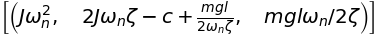

In [4]:
import sympy as sp
z, wn = sp.symbols('zeta omega_n')
kp, kd, ki = sp.symbols('k_p k_d k_i')
mgl,c,J = sp.symbols('mgl c J')
sp.init_printing()

f1 = mgl/ki-2*z/wn
f2 = (c+kd)/ki-mgl*kp/(ki**2)-1/(wn**2)
f3 = J/ki-kp*(c+kd)/(ki**2)+mgl*kp**2/(ki**3)
sp.solve([f1, f2, f3],[kp, kd, ki])

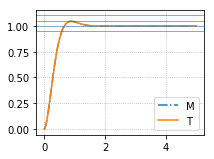

In [5]:
g  = 9.81                  # 重力加速度[m/s^2]
l  = 0.141                 # アームの長さ[m]
m  = 0.3                   # アームの質量[kg]
c  = 1.33e-2               # 粘性摩擦係数
J  = 9.56e-3               # 慣性モーメント

omega_n = 5
zeta = 0.707
M = tf([0,omega_n**2],[1,2*zeta*omega_n,omega_n**2])

kP = omega_n**2*J
kI = omega_n*m*g*l/(2*zeta)
kD = 2*zeta*omega_n*J + m*g*l/(2*zeta*omega_n) - c
T = tf([kP,kI],[J, c+kD, m*g*l+kP, kI])

yM, tM = step(M, np.arange(0, 5, 0.01))
yT, tT = step(T, np.arange(0, 5, 0.01))

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(tM, yM, label='M', ls = '-.')
ax.plot(tT, yT, label='T') 
ax.legend()

ax.axhline(1, linewidth=0.5)
ax.axhline(1.05, linewidth=0.5, c='r')  
ax.axhline(0.95, linewidth=0.5, c='r')  
ax.axhline(1.1, linewidth=0.5, c='g') 

ax.grid(ls=':')

### 制御系設計の例

In [6]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数[kg*m^2/s]
J  = 1.0e-2              # 慣性モーメント[kg*m^2]

ref = 30

P = tf( [0,1], [J, mu, M*g*l] )

In [7]:
alpha1 = 2
alpha2 = 2
omega_n = 12

kp = J*alpha1*omega_n**2-M*g*l
ki = J*omega_n**3
kd = J*alpha2*omega_n - mu

K1 = tf([kd, kp, ki], [1, 0])
K2 = tf([0, ki], [kd, kp, ki])

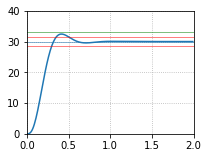

In [8]:
Gyz = feedback(P*K1, 1)

Td = np.arange(0, 2, 0.01)
r = 1*(Td>0)

z, t, _ = lsim(K2, r, Td, 0)

fig, ax = plt.subplots(figsize=(3, 2.3))

y, _, _ = lsim(Gyz, z, Td, 0)
ax.plot(t, y*ref, label='I-PD')

ax.axhline(ref, linewidth=0.5)
ax.axhline(ref*1.05, linewidth=0.5, c='r')  
ax.axhline(ref*0.95, linewidth=0.5, c='r')  
ax.axhline(ref*1.1, linewidth=0.5, c='g')  
ax.grid(ls=':')

ax.set_xlim(0, 2)
ax.set_ylim(0,40)

fig.tight_layout()

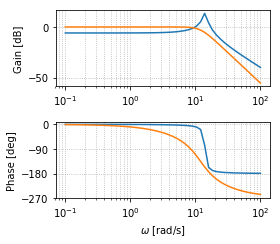

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P/(1+P), logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

gain, phase, w = bode(K2*Gyz, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-190,10)
ax[1].set_yticks([-270,-180,-90,0])

fig.tight_layout()

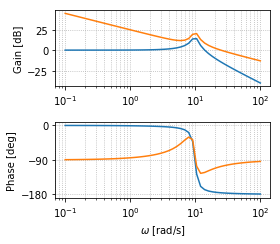

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

gain, phase, w = bode(P*K1, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-190,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()